# Bushveld Igneous Complex (South Africa) - Gravity and precomputed graviy-related data

This gravity contains ground gravity observations over the area that comprises
the Bushveld Igenous Complex in Southern Africa, including preprocessed gravity
fields such as the *gravity disturbance* and the *bouguer gravity disturbance*
(topography-free gravity disturbance). In addition, the dataset contains the
heights of the observation points referenced on the WGS84 reference ellipsoid
and over the mean sea-level (what can be considered to be the geoid). This
dataset was built upon a portion of the Southern Africa gravity compilation
available through [NOAA NCEI](https://www.ngdc.noaa.gov/mgg/gravity/).

**Source:** [NOAA NCEI](https://www.ngdc.noaa.gov/mgg/gravity/) (gravity) and [ETOPO1](https://doi.org/10.7289/V5C8276M) (topography)

**License:** [public domain](https://ngdc.noaa.gov/ngdcinfo/privacy.html) (gravity) and [public domain](https://ngdc.noaa.gov/mgg/global/dem_faq.html#sec-2.4) (topography)

## Notes

CHANGEME: Any relevant notes about this dataset, such as data format, original coordinate systems, or anything else that's relevant.

In [1]:
import os
import pygmt
import pyproj
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import boule as bl
import harmonica as hm
import ensaio
import pooch

## Download the gravity data

Use [Ensaio](https://github.com/fatiando/ensaio) to download the original data file to our computer.

In [2]:
fname = ensaio.fetch_southern_africa_gravity(version=1)
print(f"size: {os.path.getsize(fname) / 1e6} Mb")

size: 0.138108 Mb


## Read the data

Use pandas to read the data.

In [3]:
data = pd.read_csv(fname)
data

,longitude,latitude,height_sea_level_m,gravity_mgal
0,18.34444,-34.12971,32.2,979656.12
1,18.36028,-34.08833,592.5,979508.21
2,18.37418,-34.19583,18.4,979666.46
3,18.40388,-34.23972,25.0,979671.03
4,18.41112,-34.16444,228.7,979616.11
...,...,...,...,...
14354,21.22500,-17.95833,1053.1,978182.09
14355,21.27500,-17.98333,1033.3,978183.09
14356,21.70833,-17.99166,1041.8,978182.69
14357,21.85000,-17.95833,1033.3,978193.18


## Crop it to the Bushveld Igneous Complex area

Keep only the observations located in the region of interest.

In [4]:
region = (25, 32, -27, -23)

inside = vd.inside((data.longitude, data.latitude), region)
data = data[inside]
data

,longitude,latitude,height_sea_level_m,gravity_mgal
8648,25.01500,-26.26334,1230.2,978681.38
8649,25.01932,-26.38713,1297.0,978669.02
8650,25.02499,-26.39667,1304.8,978669.28
8651,25.04500,-26.07668,1165.2,978681.08
8652,25.07668,-26.35001,1262.5,978665.19
...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85
12975,31.52499,-23.30000,280.7,978798.55
12976,31.54832,-23.19333,245.7,978803.55
12977,31.57333,-23.84833,226.8,978808.44


## Plot the data 

Make a quick plot to make sure the data look OK. This plot will be used as a preview of the dataset.

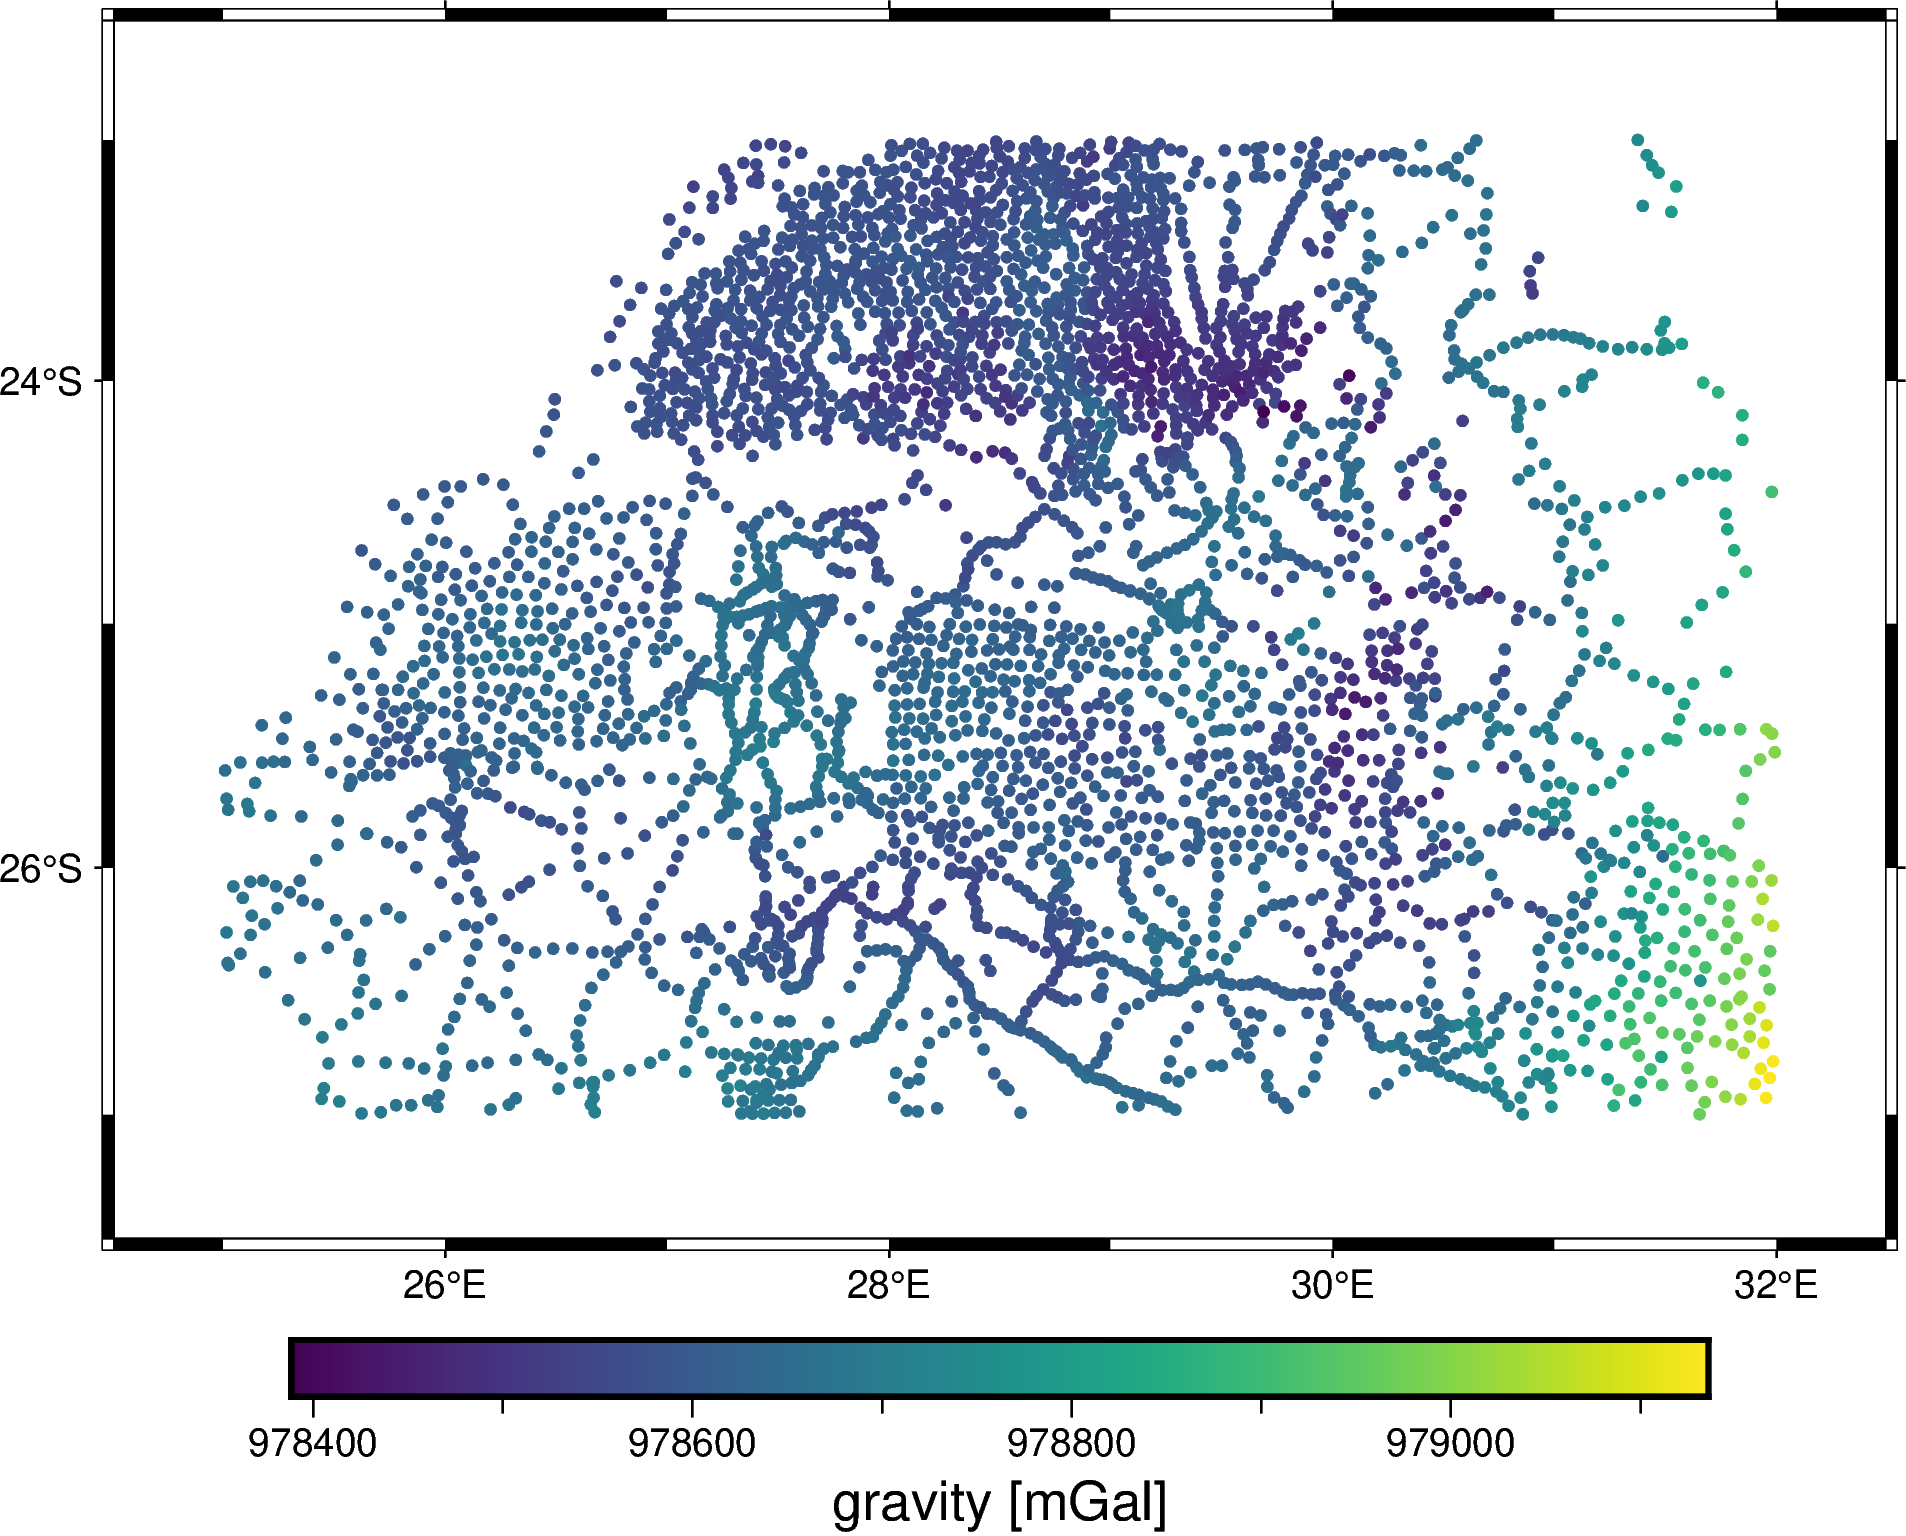

In [5]:
fig = pygmt.Figure()
fig.basemap(
    region=[
        data.longitude.min() - 0.5,
        data.longitude.max() + 0.5,
        data.latitude.min() - 0.5,
        data.latitude.max() + 0.5,
    ],
    projection="M15c",
    frame=True,
)
pygmt.makecpt(cmap="viridis", series=[data.gravity_mgal.min(), data.gravity_mgal.max()])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity_mgal,
    cmap=True,
    style="c0.1c",
)
fig.colorbar(frame='af+l"gravity [mGal]"')
fig.show()

## Project the data coordinates

Some of the following computations need our coordinates to be in plain Cartesian ones.

In [6]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)

data = data.assign(easting_m=easting, northing_m=northing)
data

,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06
...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06


## Compute ellipsoidal heights

For many applications, we need our gravity data observation heights to be referenced on the ellipsoid instead of above the mean sea level (geoid).
To do so we need to subtract the geoid height (referenced over the ellipsoid) from the observation heights in our data.

### Download global geoid

Download a global grid of geoid height using [Ensaio](https://www.fatiando.org/ensaio) and load it with [Xarray](https://xarray.dev/):

In [7]:
geoid_fname = ensaio.fetch_earth_geoid(version=1)

geoid = xr.load_dataarray(geoid_fname)
geoid

<xarray.DataArray 'geoid' (latitude: 1081, longitude: 2161)>
array([[-29.5     , -29.5     , -29.5     , ..., -29.5     , -29.5     ,
        -29.5     ],
       [-29.5     , -29.5     , -29.5     , ..., -29.5     , -29.5     ,
        -29.5     ],
       [-29.6     , -29.6     , -29.6     , ..., -29.6     , -29.6     ,
        -29.6     ],
       ...,
       [ 14.7     ,  14.7     ,  14.7     , ...,  14.7     ,  14.7     ,
         14.7     ],
       [ 15.2     ,  15.2     ,  15.2     , ...,  15.2     ,  15.2     ,
         15.2     ],
       [ 15.400001,  15.400001,  15.400001, ...,  15.400001,  15.400001,
         15.400001]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Geoid height (EIGEN-6C4) with respect to WGS84
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       geoid height
    standard_name:   geoid_height_above_reference_ellipsoid
    description:     height of the geoid with respect to the WGS84 ellipsoid
    units:           m
    actual_range:    [-106.5   86. ]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

### Crop the geoid grid

We will crop the geoid grid to a padded region around the Bushveld area.

In [8]:
region_pad = vd.pad_region(region, 2)

geoid = geoid.sel(longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:]))
geoid

<xarray.DataArray 'geoid' (latitude: 49, longitude: 67)>
array([[32.5      , 32.2      , 31.9      , ..., 18.7      , 18.800001 ,
        18.9      ],
       [32.7      , 32.5      , 32.2      , ..., 18.6      , 18.7      ,
        18.800001 ],
       [32.9      , 32.7      , 32.4      , ..., 18.5      , 18.6      ,
        18.6      ],
       ...,
       [18.800001 , 18.7      , 18.5      , ...,  2.3      ,  2.1000001,
         1.8000001],
       [18.4      , 18.4      , 18.300001 , ...,  1.9      ,  1.6      ,
         1.3000001],
       [18.2      , 18.2      , 18.1      , ...,  1.7      ,  1.2      ,
         1.       ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 23.0 23.17 23.33 23.5 ... 33.67 33.83 34.0
  * latitude   (latitude) float64 -29.0 -28.83 -28.67 ... -21.33 -21.17 -21.0
Attributes:
    Conventions:     CF-1.8
    title:           Geoid height (EIGEN-6C4) with respect to WGS84
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       geoid height
    standard_name:   geoid_height_above_reference_ellipsoid
    description:     height of the geoid with respect to the WGS84 ellipsoid
    units:           m
    actual_range:    [-106.5   86. ]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

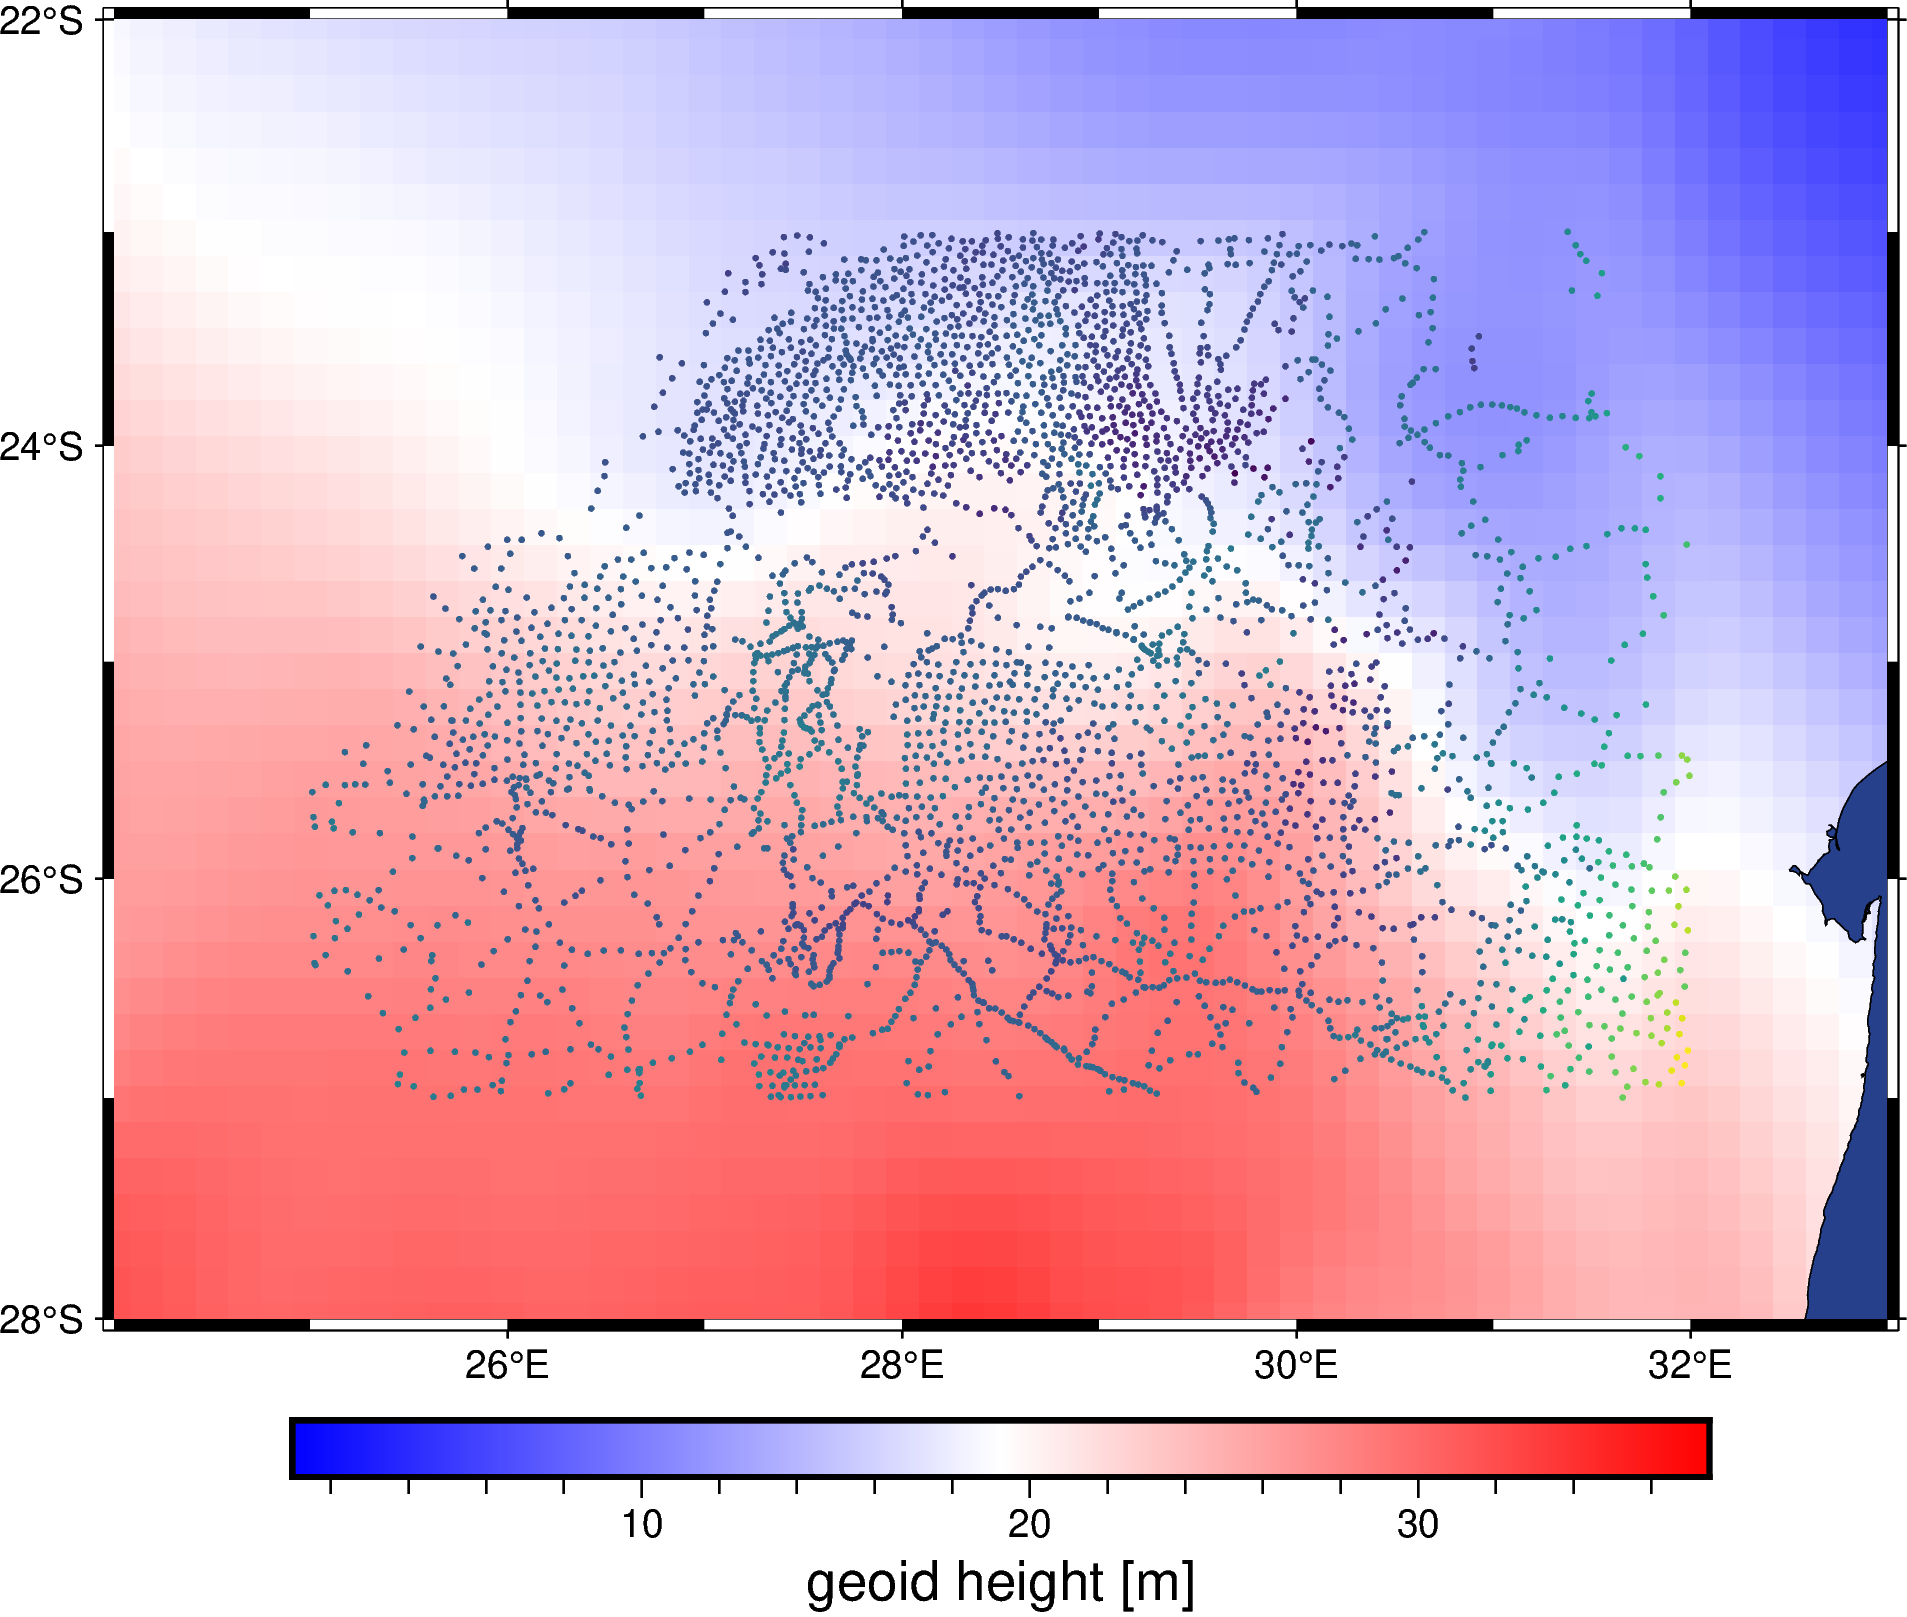

In [9]:
fig = pygmt.Figure()
fig.basemap(
    region=[
        data.longitude.min() - 1,
        data.longitude.max() + 1,
        data.latitude.min() - 1,
        data.latitude.max() + 1,
    ],
    projection="M15c",
    frame=True,
)

scale = vd.maxabs(geoid)
pygmt.makecpt(cmap="polar", series=[-scale, scale], no_bg=True)
fig.grdimage(geoid, cmap="polar")
fig.colorbar(frame='af+l"geoid height [m]"')

pygmt.makecpt(cmap="viridis", series=[data.gravity_mgal.min(), data.gravity_mgal.max()])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity_mgal,
    cmap=True,
    style="c0.05c",
)
# fig.colorbar(frame='af+l"gravity [mGal]"')
fig.coast(shorelines=True, water="royalblue4", area_thresh=1e4)
fig.show()

### Project the geoid grid

Project the geoid grid to plain coordinates.

In [10]:
geoid_proj = vd.project_grid(geoid, projection, method="nearest")
geoid_proj

/home/santi/.mambaforge/envs/fatiando-data-bushveld-gravity/lib/python3.9/site-packages/verde/base/base_classes.py:463: FutureWarning: The 'spacing', 'shape' and 'region' arguments will be removed in Verde v2.0.0. Please use the 'verde.grid_coordinates' function to define grid coordinates and pass them as the 'coordinates' argument.
  warnings.warn(


<xarray.DataArray 'geoid' (northing: 49, easting: 67)>
array([[32.35     , 32.35     , 31.9      , ..., 18.75     , 18.800001 ,
        18.9      ],
       [32.6      , 32.6      , 32.2      , ..., 18.6      , 18.7      ,
        18.800001 ],
       [32.800003 , 32.800003 , 32.4      , ..., 18.5      , 18.6      ,
        18.6      ],
       ...,
       [18.75     , 18.75     , 18.5      , ...,  2.3      ,  2.1000001,
         1.8000001],
       [18.3      , 18.3      , 18.2      , ...,  2.075    ,  1.4000001,
         1.1500001],
       [18.3      , 18.3      , 18.2      , ...,  2.075    ,  1.4000001,
         1.1500001]], dtype=float32)
Coordinates:
  * easting   (easting) float64 2.323e+06 2.339e+06 ... 3.417e+06 3.433e+06
  * northing  (northing) float64 -3.043e+06 -3.025e+06 ... -2.174e+06 -2.156e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

### Interpolate geoid heights on the observation points

In order to get the geoid heights on the observation points we need to interpolate the geoid grid on the same points where the gravity was measured.

In [11]:
# Unravel the grid so that we can pass it to the interpolator
geoid_table = vd.grid_to_table(geoid_proj)
interpolator = vd.ScipyGridder(method="cubic")
interpolator.fit((geoid_table.easting, geoid_table.northing), geoid_table.geoid)

# Predict the geoid height at same locations as the observation points
data = data.assign(geoid_m=interpolator.predict((data.easting_m, data.northing_m)))
data = data.assign(height_geometric_m=data.height_sea_level_m + data.geoid_m)
data

,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m,geoid_m,height_geometric_m
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06,27.274535,1257.474535
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06,27.574150,1324.574150
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06,27.601322,1332.401322
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06,26.907148,1192.107148
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06,27.471792,1289.971792
...,...,...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06,12.210241,312.710241
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06,11.986630,292.686630
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06,11.892670,257.592670
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06,12.399065,239.199065


## Compute gravity disturbance

The gravity disturbance is defined as the observed gravity minus the normal gravity, i.e. the gravity field generated by the reference ellipsoid.
We can use Boule to compute the normal gravity of the WGS84 ellipsoid on each observation point:

In [12]:
normal_gravity = bl.WGS84.normal_gravity(data.latitude, data.height_geometric_m)

data = data.assign(gravity_disturbance_mgal=data.gravity_mgal - normal_gravity)
data

,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m,geoid_m,height_geometric_m,gravity_disturbance_mgal
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06,27.274535,1257.474535,25.081592
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06,27.574150,1324.574150,24.538158
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06,27.601322,1332.401322,26.526960
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06,26.907148,1192.107148,17.954814
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06,27.471792,1289.971792,12.700307
...,...,...,...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06,12.210241,312.710241,-4.783965
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06,11.986630,292.686630,48.012766
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06,11.892670,257.592670,49.161771
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06,12.399065,239.199065,5.116904


## Calculate topography-free gravity disturbance

The topography-free gravity disturbance is defined as the gravity disturbance without the gravitational effect of the topography.
So, to calculate it we need to compute the gravitational effect of the topography.
We can do it by forward modelling a topography grid using [Harmonica](https://www.fatiando.org/harmonica).

### Download a topography grid for Southern Africa

In [13]:
doi = "10.5281/zenodo.6481379"
fname = "southern-africa-topography.nc"

topography_fname = pooch.retrieve(f"doi:{doi}/{fname}", known_hash="md5:609d14fe4e551c5dcf320cdceedd30e8")
print(f"size: {os.path.getsize(topography_fname) / 1e6} Mb")

size: 1.701373 Mb


Load the topography grid through Xarray:

In [14]:
topography = xr.load_dataarray(topography_fname)
topography

<xarray.DataArray 'topography' (latitude: 1182, longitude: 1371)>
array([[-5039., -5027., -5014., ..., -3846., -3867., -3873.],
       [-5036., -5021., -5007., ..., -3839., -3863., -3872.],
       [-5031., -5016., -5001., ..., -3835., -3860., -3870.],
       ...,
       [-2906., -2901., -2884., ...,   173.,   134.,   118.],
       [-2908., -2906., -2888., ...,   132.,   119.,   118.],
       [-2912., -2910., -2894., ...,   122.,   120.,   128.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 10.92 10.93 10.95 10.97 ... 33.72 33.73 33.75
  * latitude   (latitude) float64 -36.0 -35.98 -35.97 ... -16.35 -16.33 -16.32
Attributes:
    Conventions:    CF-1.8
    title:          Topographic and bathymetric height for Southern Africa ob...
    crs:            WGS84
    source:         Downloaded from NOAA website (https://ngdc.noaa.gov/mgg/g...
    license:        public domain
    references:     https://doi.org/10.7289/V5C8276M
    long_name:      topographic height above mean sea level
    standard_name:  height_above_mean_sea_level
    description:    height topography/bathymetry referenced to mean sea level
    units:          m
    actual_range:   [-5685.  3376.]
    noaa_metadata:  Conventions: COARDS/CF-1.0\ntitle: ETOPO1_Ice_g_gmt4.grd\...

### Crop it to a padded region around the Bushveld area

In [15]:
region_pad = vd.pad_region(region, 1)

topography = topography.sel(longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:]))
topography

<xarray.DataArray 'topography' (latitude: 360, longitude: 540)>
array([[ 1408.,  1403.,  1398., ..., -1316., -1336., -1365.],
       [ 1413.,  1406.,  1400., ..., -1305., -1319., -1341.],
       [ 1415.,  1409.,  1402., ..., -1295., -1306., -1323.],
       ...,
       [  970.,   972.,   973., ...,   120.,   122.,   120.],
       [  970.,   973.,   974., ...,   120.,   123.,   121.],
       [  967.,   970.,   974., ...,   122.,   123.,   122.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 24.02 24.03 24.05 24.07 ... 32.97 32.98 33.0
  * latitude   (latitude) float64 -28.0 -27.98 -27.97 ... -22.05 -22.03 -22.02
Attributes:
    Conventions:    CF-1.8
    title:          Topographic and bathymetric height for Southern Africa ob...
    crs:            WGS84
    source:         Downloaded from NOAA website (https://ngdc.noaa.gov/mgg/g...
    license:        public domain
    references:     https://doi.org/10.7289/V5C8276M
    long_name:      topographic height above mean sea level
    standard_name:  height_above_mean_sea_level
    description:    height topography/bathymetry referenced to mean sea level
    units:          m
    actual_range:   [-5685.  3376.]
    noaa_metadata:  Conventions: COARDS/CF-1.0\ntitle: ETOPO1_Ice_g_gmt4.grd\...

### Project the topography grid

In [16]:
topography_proj = vd.project_grid(topography, projection, method="nearest")
topography_proj

/home/santi/.mambaforge/envs/fatiando-data-bushveld-gravity/lib/python3.9/site-packages/verde/base/base_classes.py:463: FutureWarning: The 'spacing', 'shape' and 'region' arguments will be removed in Verde v2.0.0. Please use the 'verde.grid_coordinates' function to define grid coordinates and pass them as the 'coordinates' argument.
  warnings.warn(


<xarray.DataArray 'topography' (northing: 360, easting: 540)>
array([[ 1405.5,  1405.5,  1398. , ..., -1316. , -1336. , -1365. ],
       [ 1413. ,  1406. ,  1400. , ..., -1305. , -1319. , -1341. ],
       [ 1415. ,  1409. ,  1399.5, ..., -1295. , -1306. , -1323. ],
       ...,
       [  970. ,   972. ,   973. , ...,   120. ,   122. ,   120. ],
       [  968.5,   971.5,   974. , ...,   121. ,   123. ,   121.5],
       [  968.5,   971.5,   974. , ...,   121. ,   123. ,   121.5]],
      dtype=float32)
Coordinates:
  * easting   (easting) float64 2.425e+06 2.427e+06 ... 3.331e+06 3.332e+06
  * northing  (northing) float64 -2.929e+06 -2.927e+06 ... -2.267e+06 -2.266e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

### Reference the topography heights on the ellipsoid

Use the geoid grid to reference the topography heights on the ellipsoid.

In [17]:
topography_geometric = topography_proj + interpolator.grid(coordinates=(topography_proj.easting, topography_proj.northing)).scalars
topography_geometric

<xarray.DataArray (northing: 360, easting: 540)>
array([[ 1436.94697775,  1436.93815022,  1429.4375138 , ...,
        -1296.6974508 , -1316.79936169, -1345.87196769],
       [ 1444.45971636,  1437.45275481,  1431.45322054, ...,
        -1285.70013972, -1299.80335475, -1321.87687791],
       [ 1446.47245764,  1440.46678955,  1430.9687241 , ...,
        -1275.69896858, -1286.80342787, -1303.87786818],
       ...,
       [  988.49670131,   990.49174936,   991.49379638, ...,
          124.27471407,   126.252194  ,   124.2376701 ],
       [  986.98855597,   989.98320778,   992.48482962, ...,
          125.2543207 ,   127.22748088,   125.70835658],
       [  986.97826502,   989.97288949,   992.47448398, ...,
          125.23156494,   127.20421396,   125.68594098]])
Coordinates:
  * easting   (easting) float64 2.425e+06 2.427e+06 ... 3.331e+06 3.332e+06
  * northing  (northing) float64 -2.929e+06 -2.927e+06 ... -2.267e+06 -2.266e+06

## Create a prism layer model

In [18]:
# Start by placing the continental density above and below the ellipsoid
topography_density = np.where(topography_geometric > 0, 2670, -2670)
# Now correct the value in the oceans (topography < 0)
topography_density = np.where(topography_proj < 0, 1040 - 2670, topography_density)

topography_model = hm.prism_layer(
    coordinates=(topography_geometric.easting, topography_geometric.northing),
    surface=topography_geometric,
    reference=0,
    properties={"density": topography_density},
)
topography_model

<xarray.Dataset>
Dimensions:   (northing: 360, easting: 540)
Coordinates:
  * easting   (easting) float64 2.425e+06 2.427e+06 ... 3.331e+06 3.332e+06
  * northing  (northing) float64 -2.929e+06 -2.927e+06 ... -2.267e+06 -2.266e+06
    top       (northing, easting) float64 1.437e+03 1.437e+03 ... 127.2 125.7
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    density   (northing, easting) int64 2670 2670 2670 2670 ... 2670 2670 2670
Attributes:
    coords_units:      meters
    properties_units:  SI

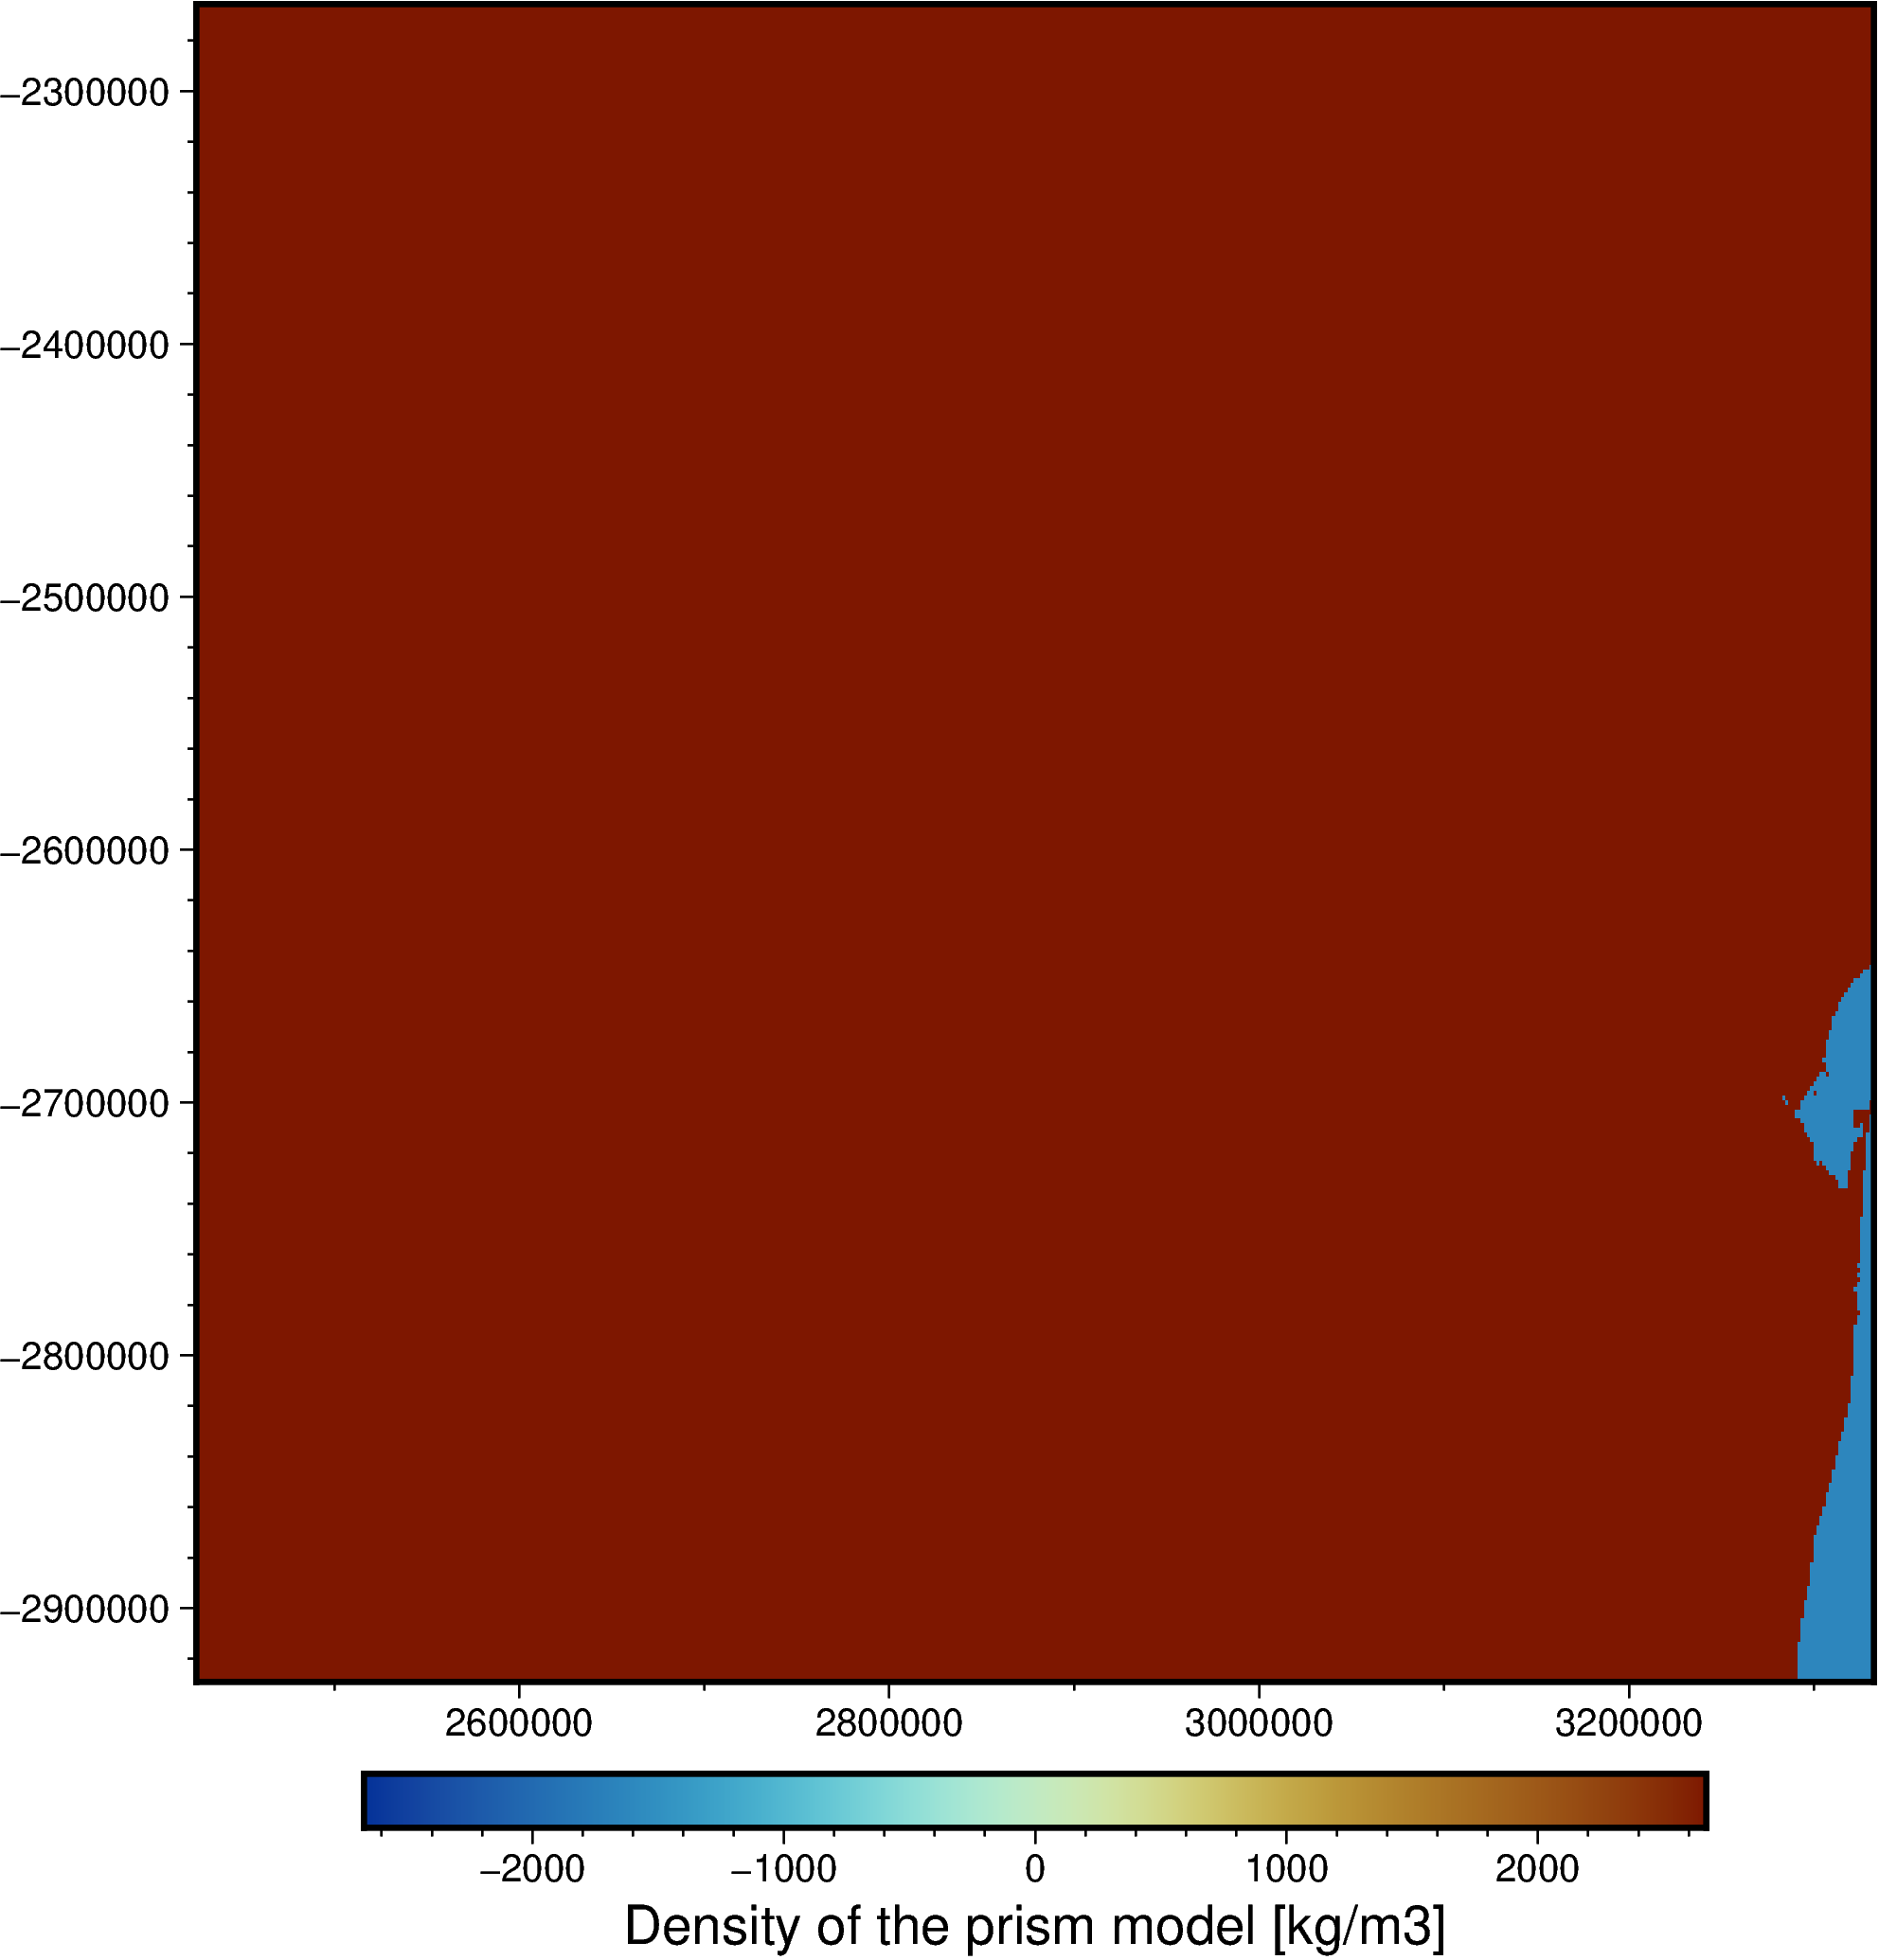

In [19]:
fig = pygmt.Figure()
scale = vd.maxabs(topography_model.density)
pygmt.makecpt(cmap="roma+h", reverse=True, series=[-scale, scale])
fig.grdimage(topography_model.density, projection="X15c", frame=True)
fig.colorbar(frame='af+l"Density of the prism model [kg/m3]"')
fig.show()

### Compute the gravitaional acceleration of the topography model on the observation points

In [20]:
terrain_effect = topography_model.prism_layer.gravity(
    (data.easting_m, data.northing_m, data.height_geometric_m), field="g_z"
)
terrain_effect

array([138.34075729, 147.20025906, 147.86628024, ...,  26.70509742,
        25.53677407,  31.10955331])

In [21]:
data = data.assign(gravity_bouguer_mgal=data.gravity_disturbance_mgal - terrain_effect)
data

,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m,geoid_m,height_geometric_m,gravity_disturbance_mgal,gravity_bouguer_mgal
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06,27.274535,1257.474535,25.081592,-113.259165
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06,27.574150,1324.574150,24.538158,-122.662101
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06,27.601322,1332.401322,26.526960,-121.339321
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06,26.907148,1192.107148,17.954814,-113.817543
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06,27.471792,1289.971792,12.700307,-130.460126
...,...,...,...,...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06,12.210241,312.710241,-4.783965,-39.543608
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06,11.986630,292.686630,48.012766,16.602026
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06,11.892670,257.592670,49.161771,22.456674
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06,12.399065,239.199065,5.116904,-20.419870


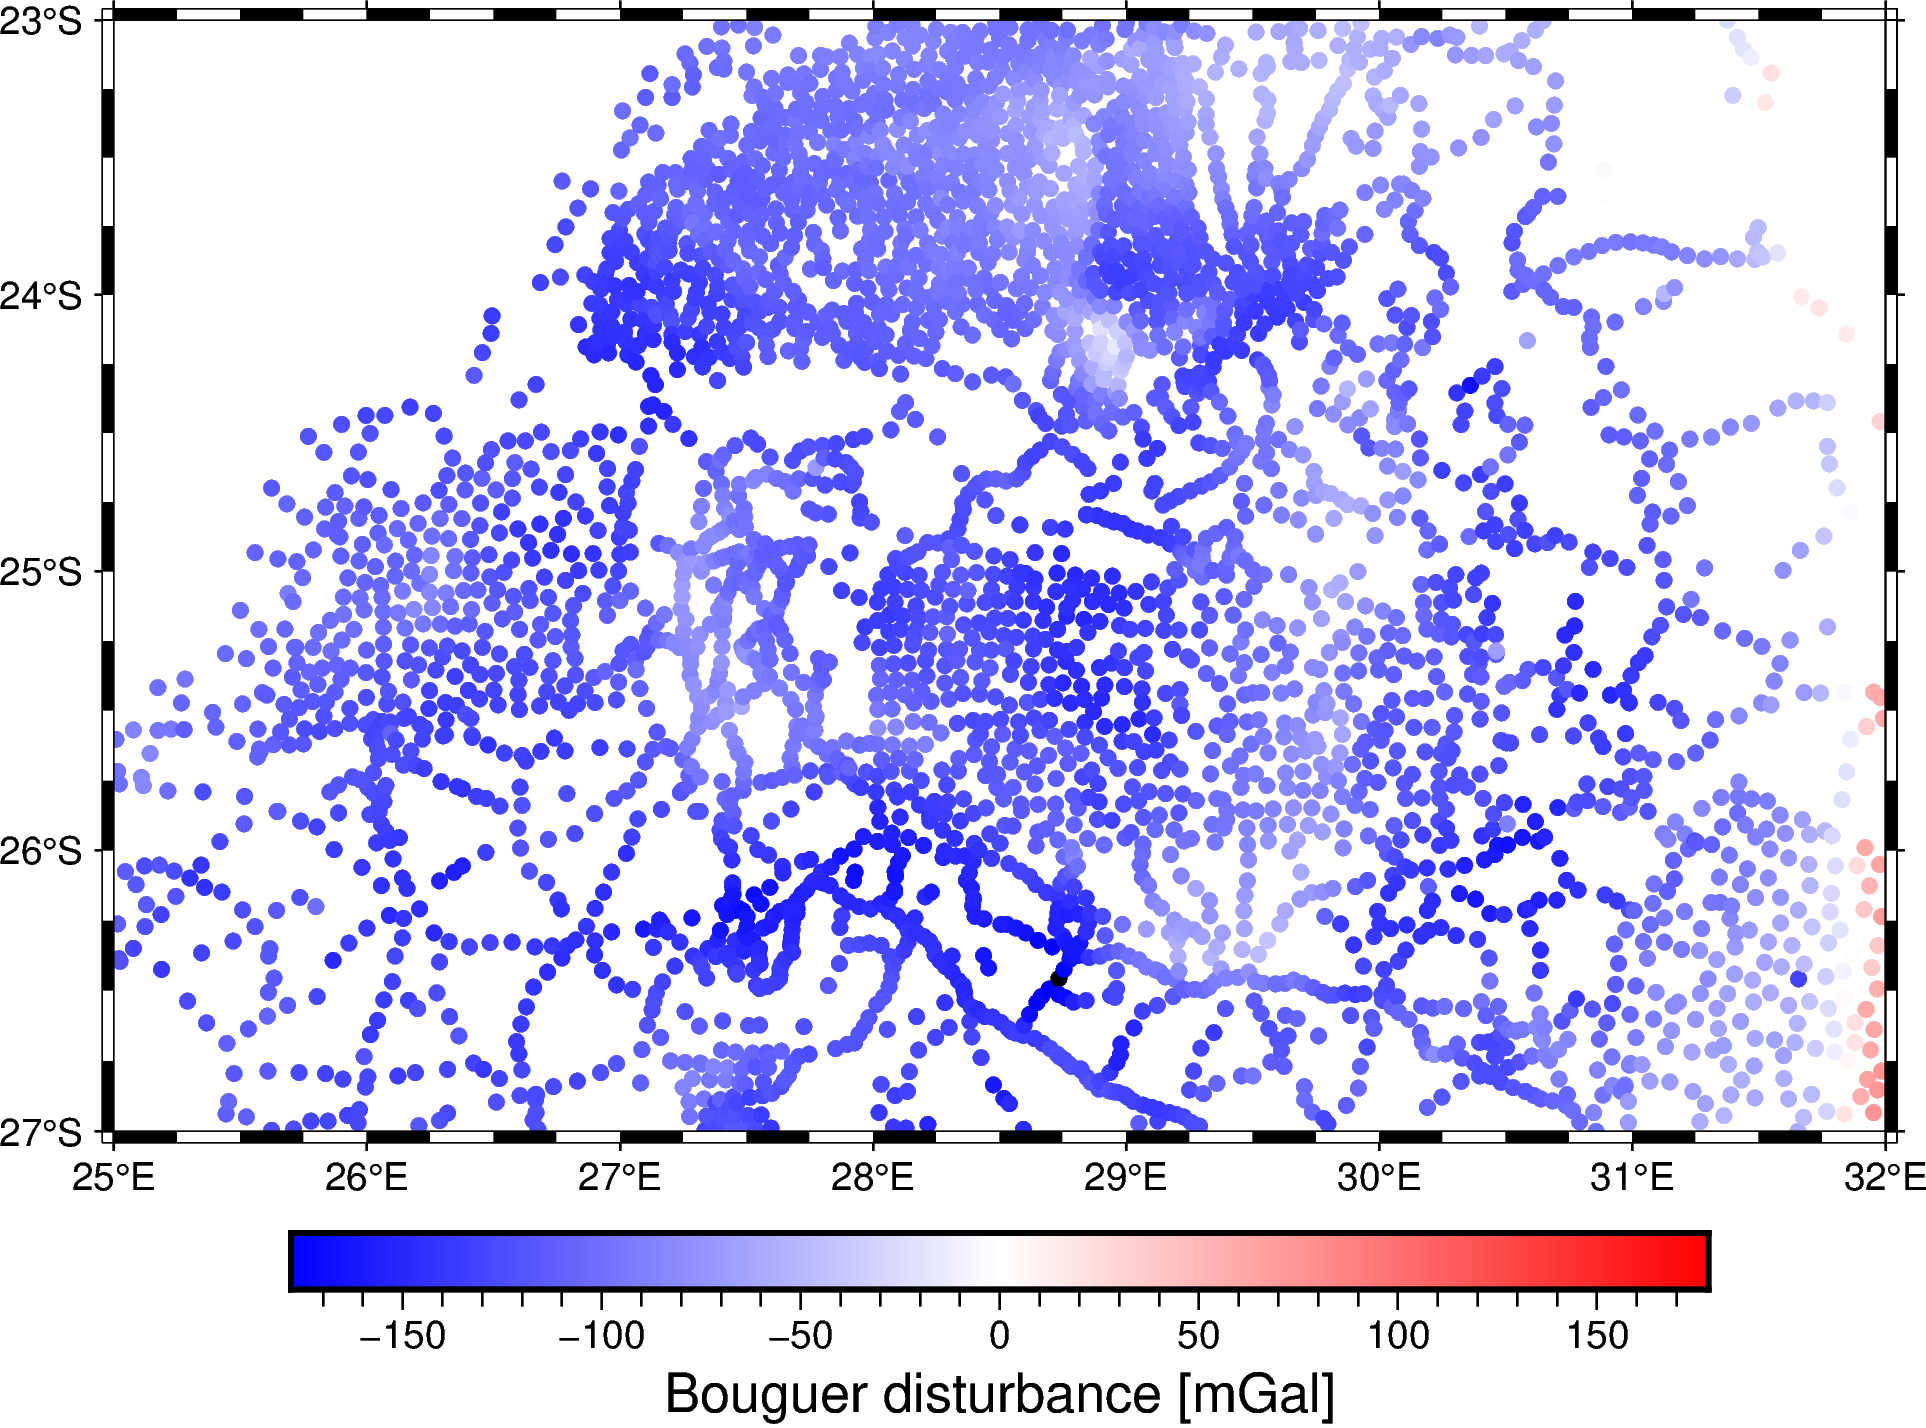

In [22]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.gravity_bouguer_mgal)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity_bouguer_mgal,
    cmap=True,
    style="c4p",
    projection="M15c", 
    frame=True,
)
fig.colorbar(frame='af+l"Bouguer disturbance [mGal]"')
fig.show()

## Plot the data 

Make a quick plot to make sure the data look OK. This plot will be used as a preview of the dataset.

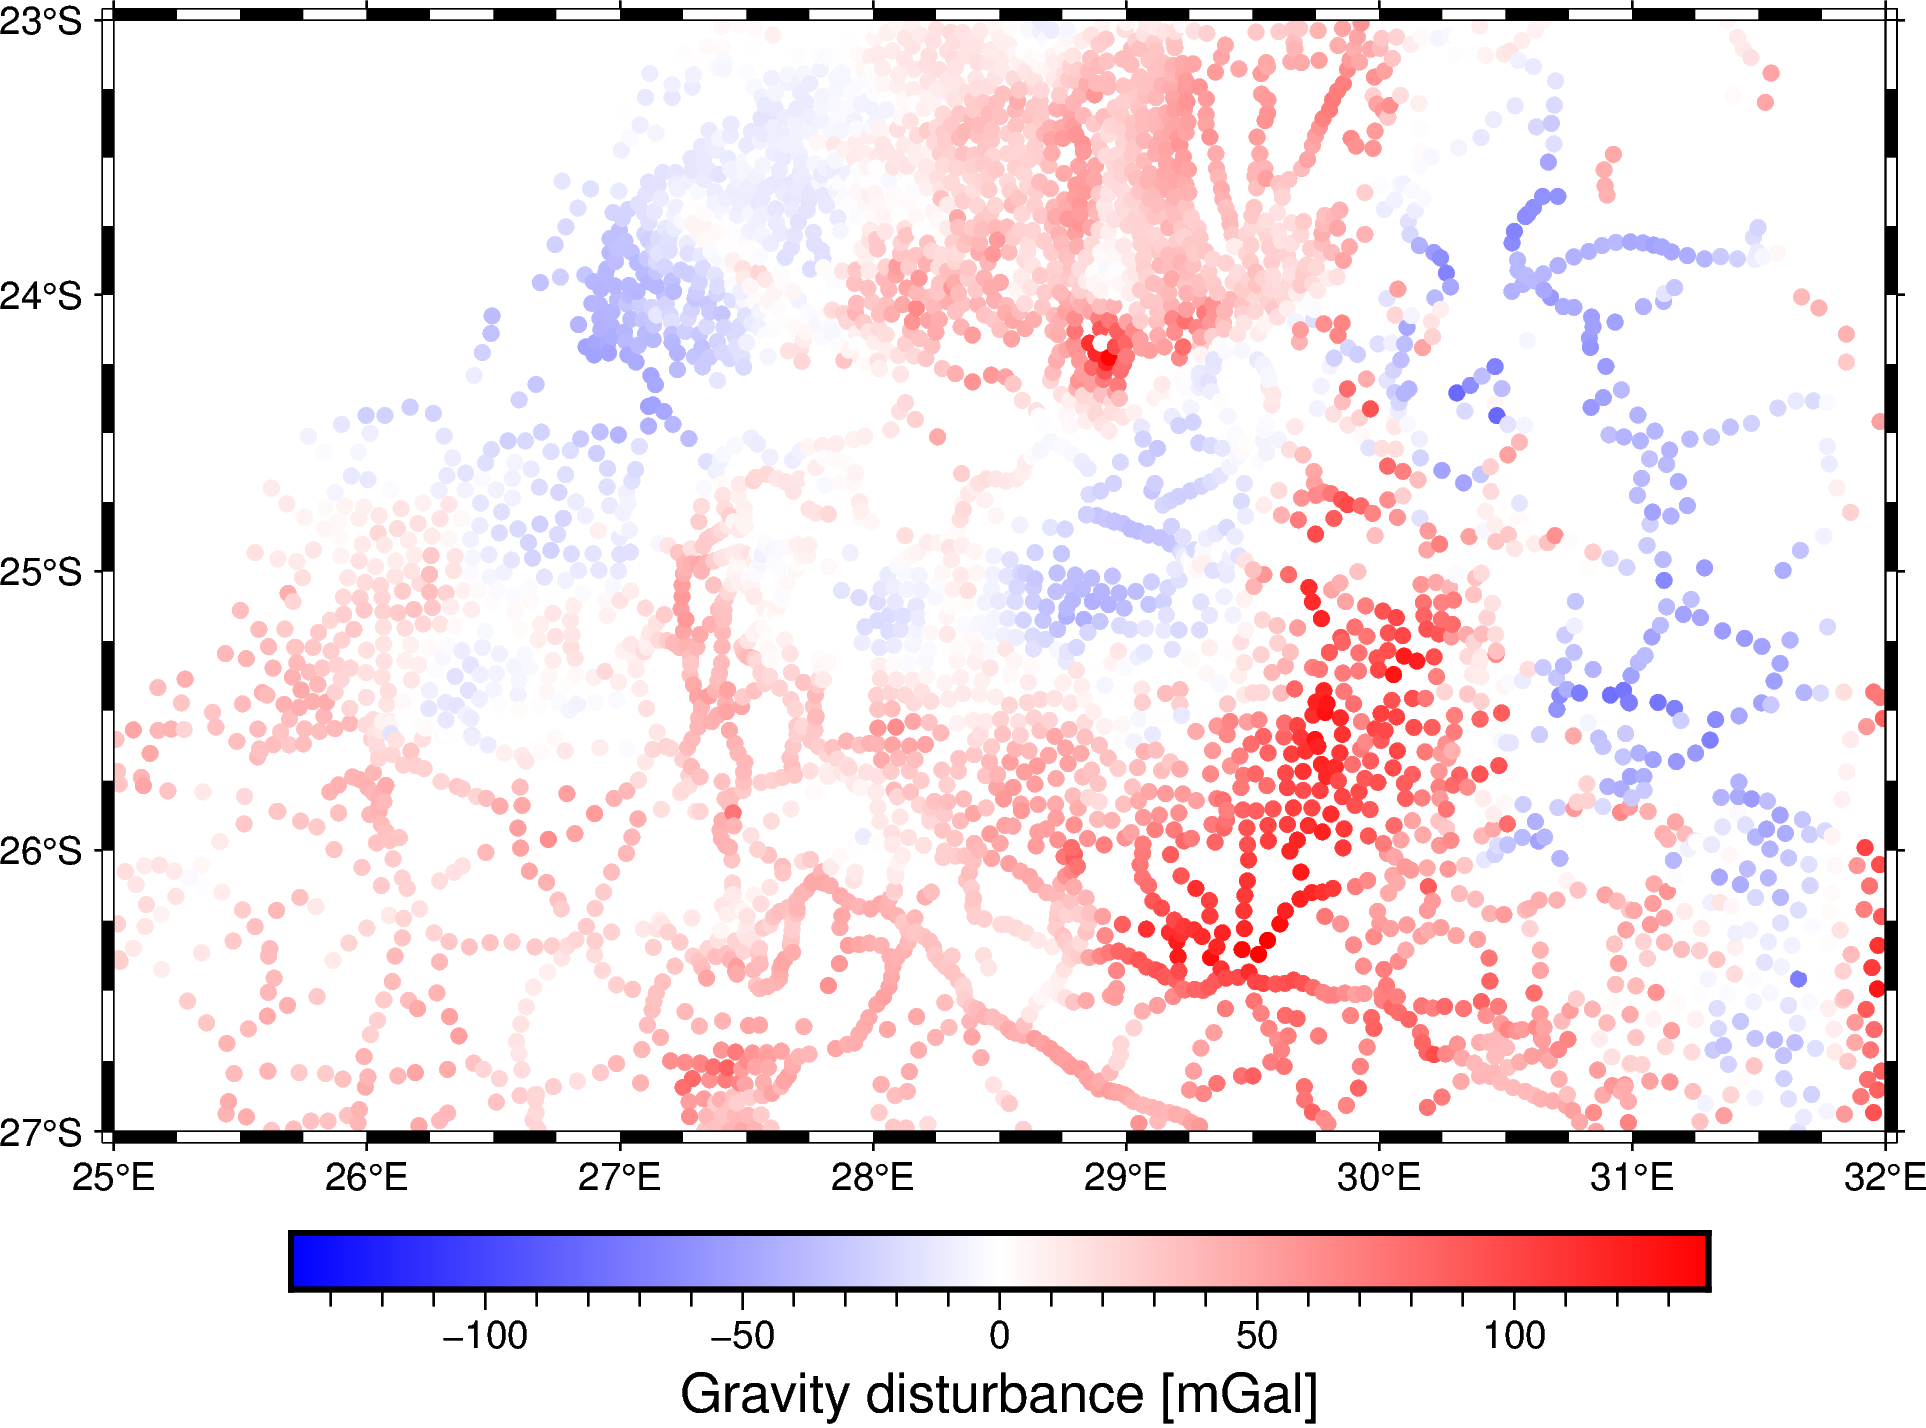

In [23]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.gravity_disturbance_mgal)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity_disturbance_mgal,
    cmap=True,
    style="c4p",
    projection="M15c", 
    frame=True,
)
fig.colorbar(frame='af+l"Gravity disturbance [mGal]"')
fig.savefig("preview.jpg", dpi=200)
fig.show()

## Export

Make a separate DataFrame to export to a compressed CSV. The conversion is needed to specify the number of significant digits to preserve in the output. Setting this along with the LZMA compression can help reduce the file size considerably. Not all fields in the original data need to be exported.

In [24]:
export = data[["longitude", "latitude", "height_sea_level_m", "height_geometric_m", "gravity_mgal", "gravity_disturbance_mgal", "gravity_bouguer_mgal"]]
export

,longitude,latitude,height_sea_level_m,height_geometric_m,gravity_mgal,gravity_disturbance_mgal,gravity_bouguer_mgal
8648,25.01500,-26.26334,1230.2,1257.474535,978681.38,25.081592,-113.259165
8649,25.01932,-26.38713,1297.0,1324.574150,978669.02,24.538158,-122.662101
8650,25.02499,-26.39667,1304.8,1332.401322,978669.28,26.526960,-121.339321
8651,25.04500,-26.07668,1165.2,1192.107148,978681.08,17.954814,-113.817543
8652,25.07668,-26.35001,1262.5,1289.971792,978665.19,12.700307,-130.460126
...,...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,312.710241,978776.85,-4.783965,-39.543608
12975,31.52499,-23.30000,280.7,292.686630,978798.55,48.012766,16.602026
12976,31.54832,-23.19333,245.7,257.592670,978803.55,49.161771,22.456674
12977,31.57333,-23.84833,226.8,239.199065,978808.44,5.116904,-20.419870


Save the data to a file and calculate the size and MD5/SHA256 hashes.

In [25]:
output = "bushveld-gravity.csv.xz"
export.to_csv(output, index=False)
print(f"file: {output}")
print(f"size: {os.path.getsize(output) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(output, alg=alg)}")

file: bushveld-gravity.csv.xz
size: 0.139072 Mb
md5:368284cc210c6bbe256e9e49e892f262
sha256:3fc1daf74a2fc3bcc3cf7f72a632518f8c6b6e306ce12fddf4055d7cb44945c8


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [26]:
data_reloaded = pd.read_csv(output)
data_reloaded

,longitude,latitude,height_sea_level_m,height_geometric_m,gravity_mgal,gravity_disturbance_mgal,gravity_bouguer_mgal
0,25.01500,-26.26334,1230.2,1257.474535,978681.38,25.081592,-113.259165
1,25.01932,-26.38713,1297.0,1324.574150,978669.02,24.538158,-122.662101
2,25.02499,-26.39667,1304.8,1332.401322,978669.28,26.526960,-121.339321
3,25.04500,-26.07668,1165.2,1192.107148,978681.08,17.954814,-113.817543
4,25.07668,-26.35001,1262.5,1289.971792,978665.19,12.700307,-130.460126
...,...,...,...,...,...,...,...
3872,31.51500,-23.86333,300.5,312.710241,978776.85,-4.783965,-39.543608
3873,31.52499,-23.30000,280.7,292.686630,978798.55,48.012766,16.602026
3874,31.54832,-23.19333,245.7,257.592670,978803.55,49.161771,22.456674
3875,31.57333,-23.84833,226.8,239.199065,978808.44,5.116904,-20.419870


Make the figure again but don't save it to a file this time.

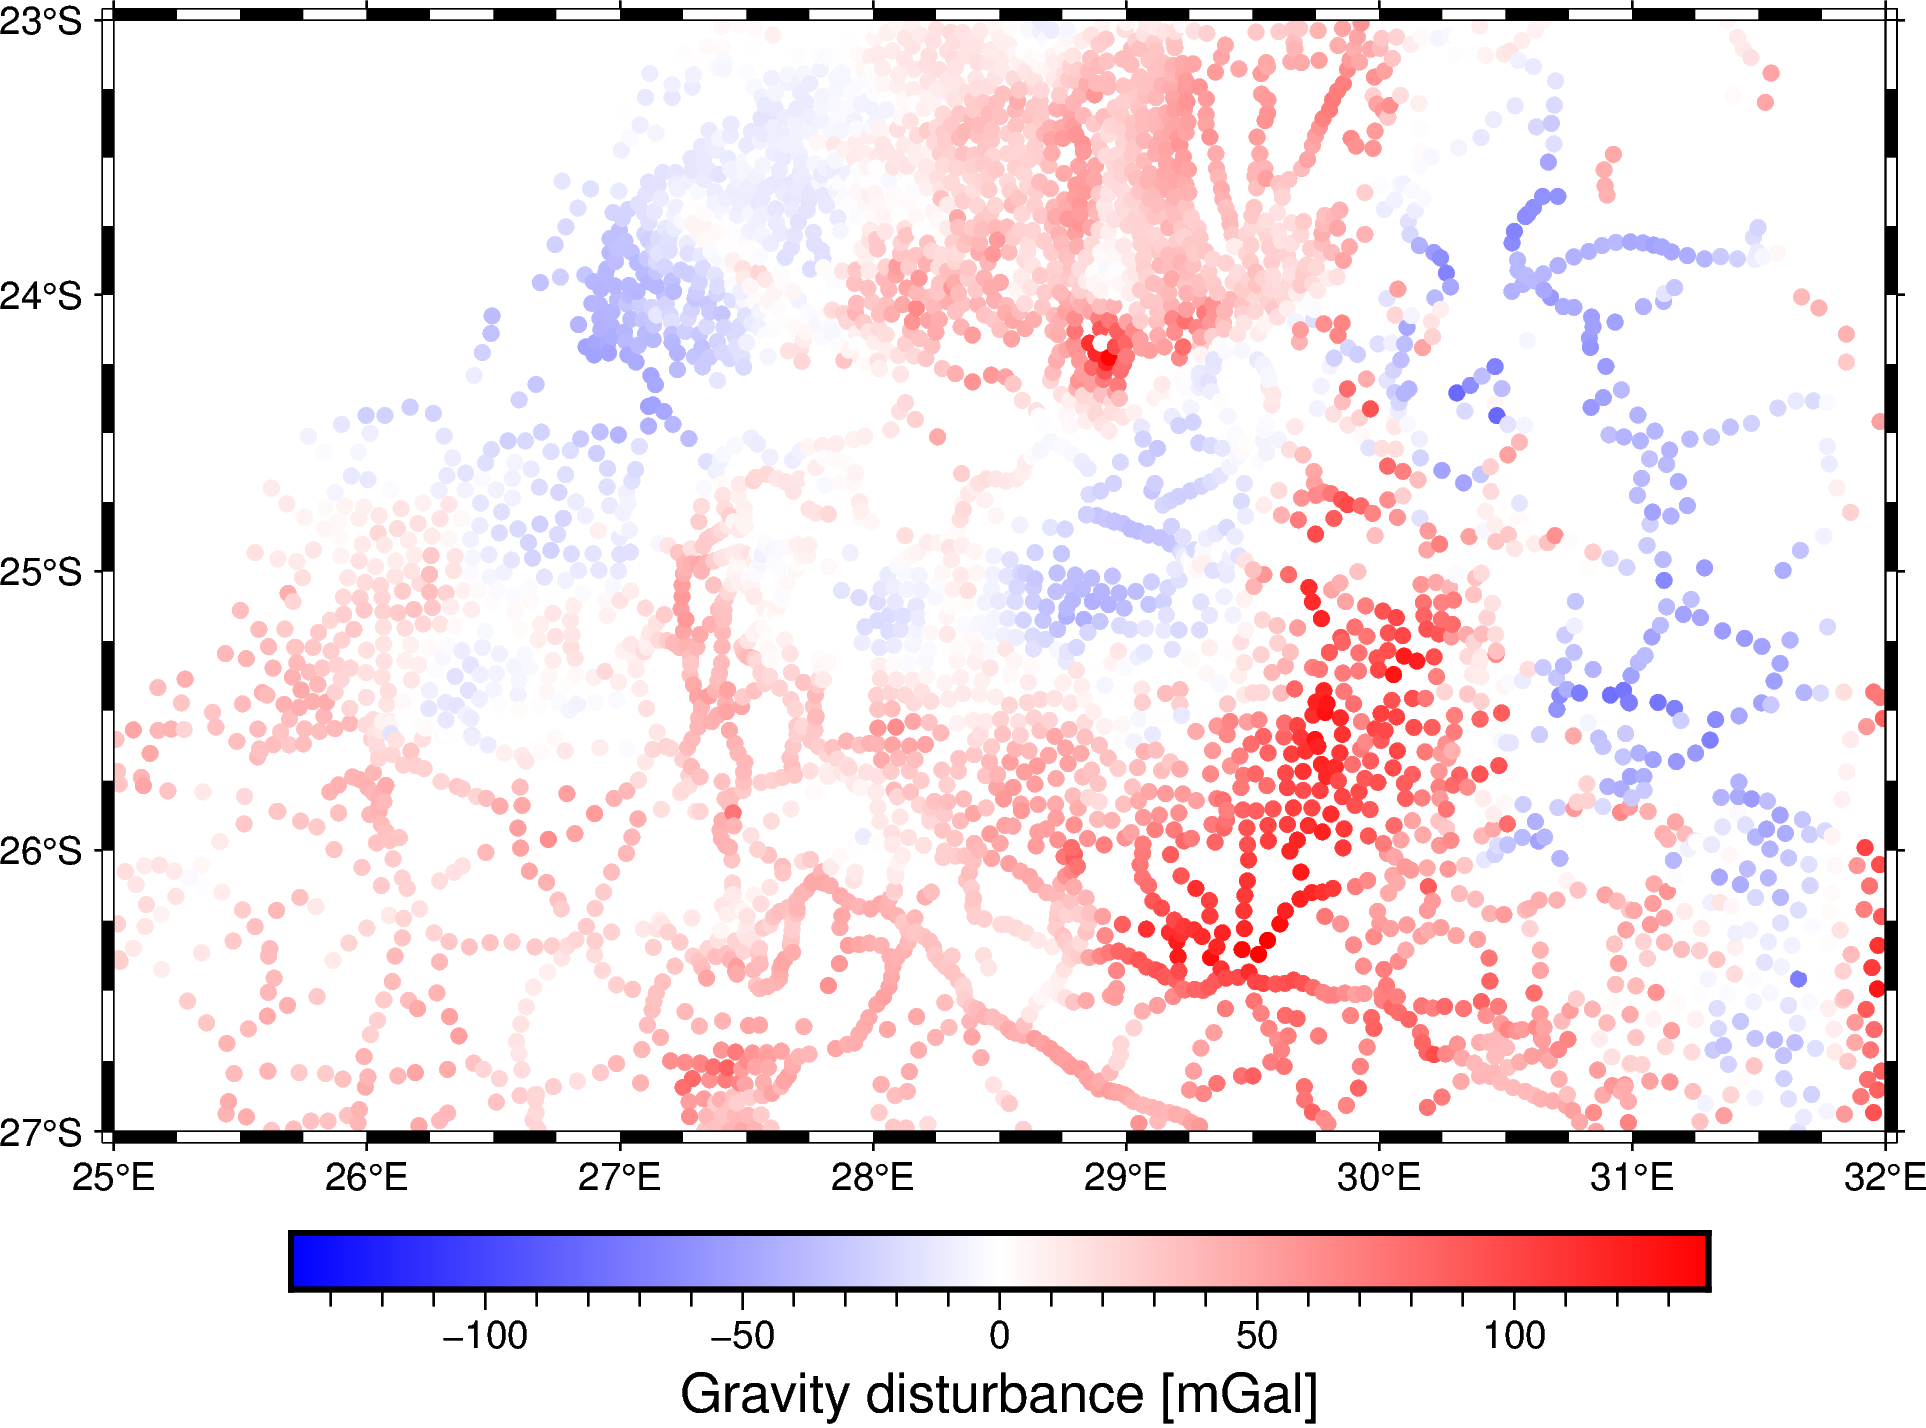

In [27]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.gravity_disturbance_mgal)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity_disturbance_mgal,
    cmap=True,
    style="c4p",
    projection="M15c", 
    frame=True,
)
fig.colorbar(frame='af+l"Gravity disturbance [mGal]"')
fig.show()